In [1]:
import os
import yaml
import numpy as np
import matplotlib.pyplot as plt
import glob
import monai
from PIL import Image
import torch
from monai.networks.nets import SwinUNETR
from monai.transforms import Transform
from monai.transforms import Compose, Flipd, Rotate90d, RandFlipd, RandRotate90d, RandSpatialCropd
import warnings
warnings.filterwarnings("ignore")
from monai.data import CacheDataset, DataLoader
import torch.nn.functional as F 
import zipfile
from tqdm import tqdm
import wandb
from datetime import datetime
from monai.transforms import Compose, Lambda
from monai.transforms import MapTransform
### our modules
from dataset import *
from training import *
from testing import *
from preprocessing import *
from models import *
from regularization import *

# Install additional packages 
#!pip install scikit-image
#!pip install wandb
#!pip install monai==1.2.0        
#!pip install imagecodecs
#!pip install opencv-python
#!pip install einops
#!pip install pyyaml

/home/jovyan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2025-04-24 11:00:14.652391: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-24 11:00:14.836415: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment varia

In [2]:
# Load config
with open("configs.yaml", "r") as f:
    config = yaml.safe_load(f)
    
dataset = config["dataset_paths"][config["dataset_index"]]
if not os.path.exists(dataset):
    print("Please update your data path to an existing folder.")
elif not set(["training", "test"]).issubset(set(os.listdir(dataset))):
    print("Please update your data path to the correct folder (should contain train and test folders).")
else:
    print(f"Congrats! You selected the correct folder : {dataset}")

Congrats! You selected the correct folder : ../datasets/DRIVE_dataset/datasets/


In [3]:
## configs

# Device
##device = torch.device("cuda" if torch.cuda.is_available() else "cpu") if config["device"] == "auto" else torch.device(config["device"])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'The used device is {device}')

# Loss function
##loss_fn = DiceLoss(sigmoid=True, batch=True) if config["loss"] == "DiceLoss" else None  # Extend as needed

batch_size = config["batch_size"]
num_workers = config["num_workers"]
n_epochs = config["n_epochs"]
ensemble_models = config["ensemble_models"]
save_path = config["save_path"]
split_ratio = config["split_ratio"]

The used device is cuda:0


## Dataset with Monai

In [4]:
def build_dict_vessels(data_path, mode='training'):
    """
    This function returns a list of dictionaries, each dictionary containing the keys 'img' and 'mask' 
    that returns the path to the corresponding image.
    
    Args:
        data_path (str): path to the root folder of the data set.
        mode (str): subset used. Must correspond to 'train' or 'test'.
        
    Returns:
        (List[Dict[str, str]]) list of the dictionaries containing the paths of images and masks.
    """
    # test if mode is correct
    if mode not in ["training", "test"]:
        raise ValueError(f"Please choose a mode in ['train', 'test']. Current mode is {mode}.")
    
    # define empty dictionary
    dicts = []
    # list all files in directory, including the path
    paths_retina = glob.glob(os.path.join(data_path, mode, 'images', '*.tif'))
    #print(paths_retina)
        
    for retina_path in paths_retina:
        image_index = os.path.basename(retina_path).split('_')[0]
        mask_path = os.path.join(data_path, mode, '1st_manual', f'{image_index}_manual1.gif')
        #padding_mask_path = os.path.join(data_path, mode, 'mask', f'{image_index}_mask.gif')
        padding_mask_path = os.path.join(data_path, mode, 'mask', f'{image_index}_{mode}_mask.gif')

        #print(padding_mask_path)

        entry = {'img': retina_path,
                }#'name': filename}

        # Add segmentation mask if it exists
        if os.path.exists(mask_path):
            #print("mask exist")
            entry['mask'] = mask_path

        # Add valid region mask (padding mask) if it exists
        if os.path.exists(padding_mask_path):
            #print("padding_mask exist")

            entry['valid_mask'] = padding_mask_path

        dicts.append(entry)

    return dicts

class LoadVesselData(Transform):
    """
    This custom Monai transform loads and processes data from the rib segmentation dataset.
    It handles RGB image loading, resizing, normalization, and binary mask conversion.
    """
    def __init__(self, keys=None):
        super().__init__()
        self.keys = keys

    def __call__(self, sample):
        try:
            # Load and process the image
            image = Image.open(sample['img']).convert('L')
            image = image.resize((512, 512), resample=Image.Resampling.NEAREST)
            image = np.array(image, dtype=np.float32) / 255.0
            image = torch.from_numpy(image).unsqueeze(0)  # [1, H, W]

            # Initialize output dictionary
            output = {
                'img': image,
                'img_meta_dict': {'affine': np.eye(2)},
                #'name': sample.get('name', 'unknown')  

            }

            # Load segmentation mask if it exists
            if 'mask' in sample and os.path.exists(sample['mask']):
                mask = Image.open(sample['mask']).convert('L')
                mask = mask.resize((512, 512), resample=Image.Resampling.NEAREST)
                mask = np.array(mask, dtype=np.uint8)
                mask = np.where(mask == 255, 1, 0)
                mask = torch.from_numpy(mask).unsqueeze(0).float()
                output['mask'] = mask
                output['mask_meta_dict'] = {'affine': np.eye(2)}

            # Load valid (padding) mask if it exists
            if 'valid_mask' in sample and os.path.exists(sample['valid_mask']):
                valid_mask = Image.open(sample['valid_mask']).convert('L')
                valid_mask = valid_mask.resize((512, 512), resample=Image.Resampling.NEAREST)
                valid_mask = np.array(valid_mask, dtype=np.uint8)
                valid_mask = np.where(valid_mask == 255, 1, 0)
                valid_mask = torch.from_numpy(valid_mask).unsqueeze(0).float()
                output['valid_mask'] = valid_mask

            return output

        except Exception as e:
            print(f"Error processing file: {e}")
            return None



In [5]:
from dataset_stare import *

if config['combination']:
    print("Using STARE+DRIVE")
    main_path = "../datasets"
    stare_images_dir = f"{main_path}/STARE_dataset/images"
    stare_masks_dir = f"{main_path}/STARE_dataset/labels-ah"
    dataset = config["dataset_paths"][config["dataset_index"]] ## Drive dataset

    stare_dicts = build_dict_stare(stare_images_dir, stare_masks_dir)
    drive_dicts = build_dict_vessels(dataset, mode="training")
    train_dict_list = drive_dicts + stare_dicts
    ###test_dict_list = build_dict_vessels(dataset, mode='test')
else:
    train_dict_list = build_dict_vessels(dataset, mode='training')

test_dict_list = build_dict_vessels(dataset, mode='test')

print(f'Number of samples in the training dataset: {len(train_dict_list)}')
print(f'Number of samples in the test dataset: {len(test_dict_list)}')

Number of samples in the training dataset: 20
Number of samples in the test dataset: 20


# Data Augmentation

In [6]:
# Don't run this if you don't want augmentations

## to fix
train_processed_list, test_processed_list = apply_augmentation(train_dict_list, test_dict_list)

Applying augmentations
Sample from train_img_list
../datasets/DRIVE_dataset/datasets/training/images/21_training.tif
Sample from test_img_list
../datasets/DRIVE_dataset/datasets/test/images/01_test.tif
All images processed with customized CLAHE.
['../datasets/CLAHE_dataset/train/clahe_21.tif', '../datasets/CLAHE_dataset/train/clahe_22.tif', '../datasets/CLAHE_dataset/train/clahe_23.tif', '../datasets/CLAHE_dataset/train/clahe_24.tif', '../datasets/CLAHE_dataset/train/clahe_25.tif', '../datasets/CLAHE_dataset/train/clahe_26.tif', '../datasets/CLAHE_dataset/train/clahe_27.tif', '../datasets/CLAHE_dataset/train/clahe_28.tif', '../datasets/CLAHE_dataset/train/clahe_29.tif', '../datasets/CLAHE_dataset/train/clahe_30.tif', '../datasets/CLAHE_dataset/train/clahe_31.tif', '../datasets/CLAHE_dataset/train/clahe_32.tif', '../datasets/CLAHE_dataset/train/clahe_33.tif', '../datasets/CLAHE_dataset/train/clahe_34.tif', '../datasets/CLAHE_dataset/train/clahe_35.tif', '../datasets/CLAHE_dataset/train/

# DataLoaders

In [7]:
train_transforms = Compose([
    LoadVesselData()
])
train_dataset = monai.data.CacheDataset(
    data=train_dict_list, 
    transform = train_transforms
)

train_dataset, val_dataset = split_dataset(train_dataset, train_ratio=split_ratio)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size,num_workers=num_workers, shuffle=True)
print(type(train_dataloader))
validation_loader = DataLoader(val_dataset, batch_size=batch_size,num_workers=num_workers, shuffle=True)

Loading dataset: 100%|██████████| 20/20 [00:00<00:00, 43.83it/s]

Dataset split: 16 training samples, 4 testing samples.
<class 'monai.data.dataloader.DataLoader'>


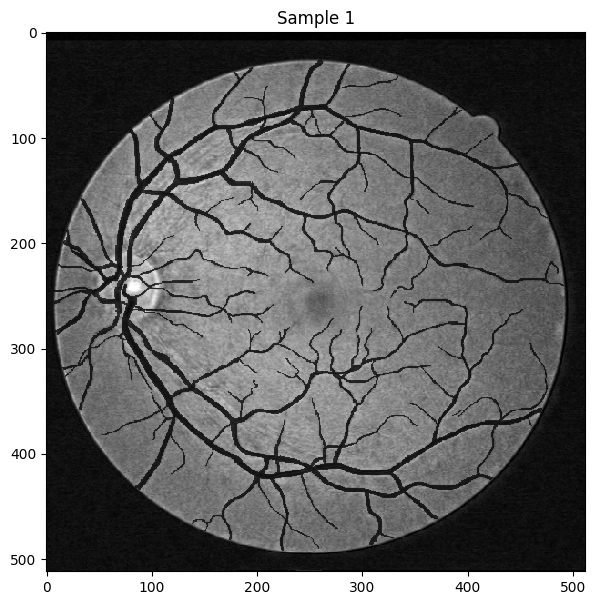

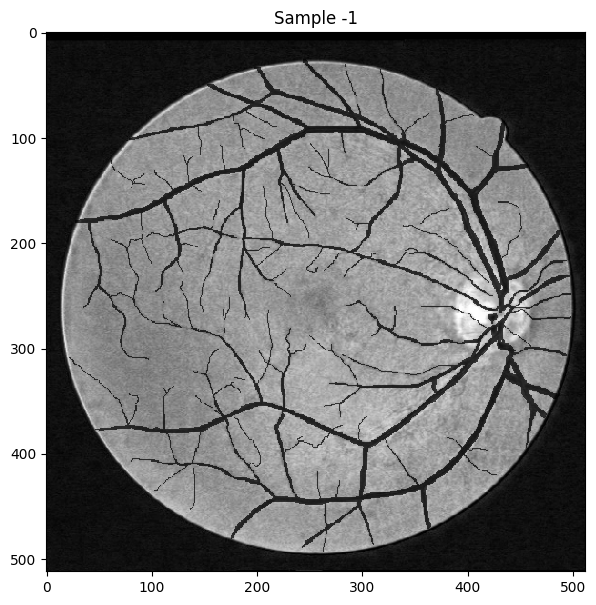

In [8]:
for i in range(len(train_dataset)):
    visualize_vessel_sample(train_dataset[1], title=f"Sample {i+1}")
    visualize_vessel_sample(train_dataset[-1], title=f"Sample {i-1}")
    break

In [9]:
for batch_data in train_dataloader:
    print("Image shape:", batch_data["img"].shape)  # Expected: [batch_size, 1, 512, 512]
    break

Image shape: torch.Size([4, 1, 512, 512])


# Models

In [10]:
# Setting up the neural network
##device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")


In [11]:
models = build_ensemble_models(config, device)
print(f"Loaded {len(models)} models: {[type(m).__name__ for m in models]}")

Loaded 4 models: ['SwinUNETR', 'UNet', 'UNet', 'UNetWithDropout']


# Training

In [12]:
import torch
import wandb
from tqdm import tqdm
from monai.metrics import DiceMetric
from monai.transforms import AsDiscrete
from regularization import *
import monai

import torch.nn.functional as F

def masked_loss(pred, target, valid_mask, criterion):##torch.nn.BCEWithLogitsLoss(reduction='none')):
    loss_map = criterion(pred, target)
    masked_loss = loss_map * valid_mask
    return masked_loss.sum() / valid_mask.sum()


def train(model, epochs, train_dataloader, validation_loader, optimizer,loss_function,n,early_stopping, device):
    dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
    post_pred = AsDiscrete(threshold=0.5)
    post_label = AsDiscrete(threshold=0.5)
    
    best_val_loss = float("inf")
    best_model_path = f"{config['save_model']}/{model.__class__.__name__}_best.pt"

    for epoch in tqdm(range(epochs), desc="Epochs"):
        model.train()    
        epoch_loss = 0.0
        step = 0

        for batch_data in train_dataloader:
            step += 1
            optimizer.zero_grad()

            imgs = batch_data["img"].float().to(device)
            masks = batch_data["mask"].float().to(device)
            if "valid_mask" in batch_data:
                valid_mask = batch_data["valid_mask"].float().to(device)
            else:
                valid_mask = torch.ones_like(batch_data["mask"]).float().to(device)

            preds = model(imgs)

            # Use masked loss
            criterion = create_loss(config)
            loss = masked_loss(preds, masks, valid_mask, criterion)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        train_loss = epoch_loss / step
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {train_loss:.4f}")

        # ----- VALIDATION -----
        step = 0
        val_loss = 0
        correct_pixels = 0
        total_pixels = 0

        dice_metric.reset()
        model.eval()
        with torch.no_grad():
            for batch_data in validation_loader:
                step += 1

                imgs = batch_data["img"].float().to(device)
                masks = batch_data["mask"].float().to(device)

                if "valid_mask" in batch_data:
                    valid_mask = batch_data["valid_mask"].float().to(device)
                else:
                    valid_mask = torch.ones_like(masks).float().to(device)

                # Forward pass
                outputs = model(imgs)

                # Compute masked loss
                loss = masked_loss(outputs, masks, valid_mask,criterion)
                val_loss += loss.item()

                # Apply sigmoid and threshold
                preds = torch.sigmoid(outputs) > 0.5

                # Apply valid mask for accuracy and Dice
                masked_preds = preds.float() * valid_mask
                masked_targets = masks * valid_mask

                # Accuracy
                correct_pixels += (masked_preds == masked_targets).sum().item()
                total_pixels += valid_mask.sum().item()  # Count only valid pixels

                # Dice Score
                dice_metric(masked_preds, masked_targets)

            val_loss = val_loss / step
            accuracy = correct_pixels / total_pixels
            mean_dice = dice_metric.aggregate().item()
            dice_metric.reset()  
            
            log_to_wandb(epoch, train_loss, val_loss, accuracy, mean_dice, batch_data, outputs)

            # Check if this is the best model so far
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), best_model_path)
                print(f"✅ Best model saved at epoch {epoch+1} with val_loss: {val_loss:.4f}")

            # Early stopping (if past warmup)
            if epoch >= 40:
                early_stopping(val_loss)
                if early_stopping.early_stop:
                    print("🛑 Early stopping triggered.")
                    break
                    
def log_to_wandb(epoch, train_loss, val_loss, accuracy, mean_dice, batch_data, outputs):
    """Logs metrics and image/mask visualizations to Weights & Biases."""
    
    imgs = batch_data['img'].detach().cpu()
    masks = batch_data['mask'].detach().cpu()
    preds = outputs.detach().cpu()

    # Optional valid_mask
    valid_mask = batch_data.get('valid_mask', None)
    if valid_mask is not None:
        valid_mask = valid_mask.detach().cpu()
    else:
        valid_mask = torch.ones_like(masks)  # fallback to all-valid

    log_imgs = []
    for img, pred, gt, vmask in zip(imgs, preds, masks, valid_mask):
        # Apply sigmoid to raw logits and binarize
        pred = torch.sigmoid(pred)
        pred_bin = torch.round(pred) * vmask  # apply valid mask
        gt_bin = gt * vmask

        # Log image with overlaid predictions and ground truth
        log_imgs.append(wandb.Image(img.squeeze(), masks=wandb_masks(pred_bin, gt_bin)))

    # Log everything
    wandb.log({
        'epoch': epoch,
        'train_loss': train_loss,
        'val_loss': val_loss,
        'pixelaccuracy': accuracy,
        'mean_dice': mean_dice,
        'results': log_imgs
    })
    


def wandb_masks(mask_output, mask_gt):
    """Creates a dictionary of masks formatted for WandB image overlay."""
    class_labels = {1: 'vessels'}

    return {
        'predictions': {'mask_data': mask_output.squeeze().numpy(), 'class_labels': class_labels},
        'ground truth': {'mask_data': mask_gt.squeeze().numpy(), 'class_labels': class_labels}
    }


In [19]:
def from_compose_to_list(transform):
    return transform.transforms

torch.manual_seed(42)
np.random.seed(42)
import random 
random.seed(42)

torch.cuda.empty_cache()

# defining the dictionary mapping each model to its Dice coefficient for l;ater computation
model_dice_dict = {}

for model in models:
    ##wandb.finish()  # ensures a clean slate

    print(f"Starting model: {model.__class__.__name__}")
    n = sum(p.numel() for p in model.parameters() if p.requires_grad) # number of parameters
    early_stopping = EarlyStopping(patience=config['early_stopping_patience'], delta=0.001)

    loss_function = create_loss(config)
    
    optimizer = create_optimizer(config, model)
    
    now = datetime.now()
    now_str = now.strftime("%Y-%m-%d_%H-%M-%S")
    print(now_str)

    run = wandb.init(
        project='DRIVE',
        name=now_str,
        config={
            #'models': str([type(m).__name__ for m in models]),
            'loss function': str(loss_function), 
            'lr': optimizer.param_groups[0]["lr"],
            'transform': from_compose_to_list(train_transforms),
            'batch_size': train_dataloader.batch_size,
            'layers': 5,
            'parameters': n,
            'early_stopping_patience': str(config['early_stopping_patience'])    
        }
    )
    wandb.config.update(config)
    run_id = run.id # We remember here the run ID to be able to write the evaluation metrics

    ### training loop
    epochs = n_epochs
    train(model, epochs, train_dataloader, validation_loader, optimizer,loss_function,n,early_stopping, device)
    
    # Store the network parameters   
    os.makedirs(config['save_model'], exist_ok=True)
    torch.save(model.state_dict(), f"{config['save_model']}/{model.__class__.__name__}.pt")
    print(f"Model saved to {config['save_model']}")
    run.finish()
    
    api = wandb.Api()
    run = api.run(f"DRIVE/{run_id}")
    
    # Final Dice
    metric_fn = monai.metrics.DiceMetric()
    dice = compute_metric(validation_loader, model, metric_fn,device)
    run.summary["dice"] = dice
    run.summary.update()
    print(f"Dice on validation set: {dice:.3f}")

    model_dice_dict[model] = dice
    
    # Final Hausdorff distance
    metric_fn = monai.metrics.HausdorffDistanceMetric()
    HausdorffDistance = compute_metric(validation_loader, model, metric_fn,device)
    run.summary["HausdorffDistance"] = HausdorffDistance
    run.summary.update()
    print(f"HausdorffDistance on validation set: {HausdorffDistance:.3f}")

Starting model: SwinUNETR
2025-04-24_11-23-35


Epochs:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1/250], Avg Loss: 0.2171


Epochs:   0%|          | 1/250 [00:03<16:32,  3.99s/it]

✅ Best model saved at epoch 1 with val_loss: 0.2570
Epoch [2/250], Avg Loss: 0.2074


Epochs:   1%|          | 2/250 [00:07<16:26,  3.98s/it]

✅ Best model saved at epoch 2 with val_loss: 0.2550
Epoch [3/250], Avg Loss: 0.1879


Epochs:   1%|          | 3/250 [00:11<16:17,  3.96s/it]

✅ Best model saved at epoch 3 with val_loss: 0.2516
Epoch [4/250], Avg Loss: 0.1744


Epochs:   2%|▏         | 4/250 [00:15<16:13,  3.96s/it]

✅ Best model saved at epoch 4 with val_loss: 0.2496
Epoch [5/250], Avg Loss: 0.1656


Epochs:   2%|▏         | 5/250 [00:19<15:47,  3.87s/it]

Epoch [6/250], Avg Loss: 0.1571


Epochs:   2%|▏         | 6/250 [00:23<15:54,  3.91s/it]

✅ Best model saved at epoch 6 with val_loss: 0.2449
Epoch [7/250], Avg Loss: 0.1527


Epochs:   3%|▎         | 7/250 [00:27<15:38,  3.86s/it]

Epoch [8/250], Avg Loss: 0.1449


Epochs:   3%|▎         | 8/250 [00:31<15:25,  3.82s/it]

Epoch [9/250], Avg Loss: 0.1421


Epochs:   4%|▎         | 9/250 [00:34<15:16,  3.80s/it]

Epoch [10/250], Avg Loss: 0.1384


Epochs:   4%|▍         | 10/250 [00:38<15:28,  3.87s/it]

✅ Best model saved at epoch 10 with val_loss: 0.2446
Epoch [11/250], Avg Loss: 0.1333


Epochs:   4%|▍         | 11/250 [00:42<15:13,  3.82s/it]

Epoch [12/250], Avg Loss: 0.1289


Epochs:   5%|▍         | 12/250 [00:46<15:05,  3.80s/it]

Epoch [13/250], Avg Loss: 0.1251


Epochs:   5%|▌         | 13/250 [00:50<14:57,  3.79s/it]

Epoch [14/250], Avg Loss: 0.1217


Epochs:   6%|▌         | 14/250 [00:53<14:47,  3.76s/it]

Epoch [15/250], Avg Loss: 0.1192


Epochs:   6%|▌         | 15/250 [00:57<14:39,  3.74s/it]

Epoch [16/250], Avg Loss: 0.1180


Epochs:   6%|▋         | 16/250 [01:01<14:39,  3.76s/it]

Epoch [17/250], Avg Loss: 0.1162


Epochs:   7%|▋         | 17/250 [01:05<14:38,  3.77s/it]

Epoch [18/250], Avg Loss: 0.1149


Epochs:   7%|▋         | 18/250 [01:08<14:28,  3.74s/it]

Epoch [19/250], Avg Loss: 0.1122


Epochs:   8%|▊         | 19/250 [01:12<14:22,  3.73s/it]

Epoch [20/250], Avg Loss: 0.1125


Epochs:   8%|▊         | 20/250 [01:15<14:02,  3.66s/it]

Epoch [21/250], Avg Loss: 0.1116


Epochs:   8%|▊         | 21/250 [01:19<13:40,  3.58s/it]

Epoch [22/250], Avg Loss: 0.1093


Epochs:   9%|▉         | 22/250 [01:23<13:46,  3.63s/it]

Epoch [23/250], Avg Loss: 0.1075


Epochs:   9%|▉         | 23/250 [01:26<13:49,  3.65s/it]

Epoch [24/250], Avg Loss: 0.1064


Epochs:  10%|▉         | 24/250 [01:30<13:51,  3.68s/it]

Epoch [25/250], Avg Loss: 0.1096


Epochs:  10%|█         | 25/250 [01:34<13:54,  3.71s/it]

Epoch [26/250], Avg Loss: 0.1084


Epochs:  10%|█         | 26/250 [01:38<14:09,  3.79s/it]

✅ Best model saved at epoch 26 with val_loss: 0.2439
Epoch [27/250], Avg Loss: 0.1083


Epochs:  11%|█         | 27/250 [01:42<14:01,  3.77s/it]

Epoch [28/250], Avg Loss: 0.1100


Epochs:  11%|█         | 28/250 [01:45<13:56,  3.77s/it]

Epoch [29/250], Avg Loss: 0.1040


Epochs:  12%|█▏        | 29/250 [01:49<13:49,  3.75s/it]

Epoch [30/250], Avg Loss: 0.1022


Epochs:  12%|█▏        | 30/250 [01:53<13:45,  3.75s/it]

Epoch [31/250], Avg Loss: 0.0998


Epochs:  12%|█▏        | 31/250 [01:56<13:37,  3.73s/it]

Epoch [32/250], Avg Loss: 0.0977


Epochs:  13%|█▎        | 32/250 [02:00<13:29,  3.71s/it]

Epoch [33/250], Avg Loss: 0.0962


Epochs:  13%|█▎        | 33/250 [02:04<13:27,  3.72s/it]

Epoch [34/250], Avg Loss: 0.0957


Epochs:  14%|█▎        | 34/250 [02:08<13:24,  3.72s/it]

Epoch [35/250], Avg Loss: 0.0922


Epochs:  14%|█▍        | 35/250 [02:11<13:20,  3.72s/it]

Epoch [36/250], Avg Loss: 0.0924


Epochs:  14%|█▍        | 36/250 [02:15<13:18,  3.73s/it]

Epoch [37/250], Avg Loss: 0.0912


Epochs:  15%|█▍        | 37/250 [02:19<13:12,  3.72s/it]

Epoch [38/250], Avg Loss: 0.0897


Epochs:  15%|█▌        | 38/250 [02:22<13:08,  3.72s/it]

Epoch [39/250], Avg Loss: 0.0892


Epochs:  16%|█▌        | 39/250 [02:26<13:03,  3.71s/it]

Epoch [40/250], Avg Loss: 0.0879


Epochs:  16%|█▌        | 40/250 [02:30<13:00,  3.72s/it]

Epoch [41/250], Avg Loss: 0.0879


Epochs:  16%|█▋        | 41/250 [02:34<12:57,  3.72s/it]

Epoch [42/250], Avg Loss: 0.0868


Epochs:  17%|█▋        | 42/250 [02:37<12:57,  3.74s/it]

EarlyStopping counter: 1 / 10
Epoch [43/250], Avg Loss: 0.0869


Epochs:  17%|█▋        | 43/250 [02:41<12:55,  3.75s/it]

EarlyStopping counter: 2 / 10
Epoch [44/250], Avg Loss: 0.0854


Epochs:  18%|█▊        | 44/250 [02:45<12:54,  3.76s/it]

EarlyStopping counter: 3 / 10
Epoch [45/250], Avg Loss: 0.0850


Epochs:  18%|█▊        | 45/250 [02:49<12:49,  3.75s/it]

EarlyStopping counter: 4 / 10
Epoch [46/250], Avg Loss: 0.0816


Epochs:  18%|█▊        | 46/250 [02:52<12:47,  3.76s/it]

EarlyStopping counter: 5 / 10
Epoch [47/250], Avg Loss: 0.0803


Epochs:  19%|█▉        | 47/250 [02:56<12:44,  3.77s/it]

EarlyStopping counter: 6 / 10
Epoch [48/250], Avg Loss: 0.0800


Epochs:  19%|█▉        | 48/250 [03:00<12:39,  3.76s/it]

Epoch [49/250], Avg Loss: 0.0780


Epochs:  20%|█▉        | 49/250 [03:04<12:35,  3.76s/it]

EarlyStopping counter: 1 / 10
Epoch [50/250], Avg Loss: 0.0778


Epochs:  20%|██        | 50/250 [03:07<12:31,  3.76s/it]

EarlyStopping counter: 2 / 10
Epoch [51/250], Avg Loss: 0.0770


Epochs:  20%|██        | 51/250 [03:11<12:29,  3.77s/it]

EarlyStopping counter: 3 / 10
Epoch [52/250], Avg Loss: 0.0759


Epochs:  21%|██        | 52/250 [03:15<12:24,  3.76s/it]

EarlyStopping counter: 4 / 10
Epoch [53/250], Avg Loss: 0.0742


Epochs:  21%|██        | 53/250 [03:19<12:20,  3.76s/it]

EarlyStopping counter: 5 / 10
Epoch [54/250], Avg Loss: 0.0739


Epochs:  22%|██▏       | 54/250 [03:22<12:14,  3.75s/it]

EarlyStopping counter: 6 / 10
Epoch [55/250], Avg Loss: 0.0724


Epochs:  22%|██▏       | 55/250 [03:26<12:10,  3.75s/it]

EarlyStopping counter: 7 / 10
Epoch [56/250], Avg Loss: 0.0718


Epochs:  22%|██▏       | 56/250 [03:30<12:07,  3.75s/it]

EarlyStopping counter: 8 / 10
Epoch [57/250], Avg Loss: 0.0711


Epochs:  23%|██▎       | 57/250 [03:34<12:02,  3.75s/it]

EarlyStopping counter: 9 / 10
Epoch [58/250], Avg Loss: 0.0716


Epochs:  23%|██▎       | 57/250 [03:37<12:17,  3.82s/it]

EarlyStopping counter: 10 / 10
🛑 Early stopping triggered.


Model saved to ../saved_models/


epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
mean_dice,▇▇▇▆▆▅█▇▇▇▆▇▇▆▅▄▄▆▅▄▆▄▄▅▄▃▄▅▄▃▃▅▆▅▁▄▄▃▄▃
pixelaccuracy,▄▅▅▅▄▁█▄▅▇▄▅▄▅▄▂▂▆▆▁▂▂▅▄▃▃▂▄▄▂▂▃▅▆▄▂▂▄▄▂
train_loss,██▇▆▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_loss,█▇▄▅▂▅▁▂▂▁▂▃▂▂▄▅▆▆▂▁▆▂▄▃▄▆▄▃▄▅▆▄▃▁▃▆▅▄▄▆
epoch,57
mean_dice,0.74828
pixelaccuracy,1.39537
train_loss,0.07156
val_loss,0.25348


Dice on validation set: 0.718
HausdorffDistance on validation set: 33.429
Starting model: UNet
2025-04-24_11-27-20


Epochs:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1/250], Avg Loss: 0.1788


Epochs:   0%|          | 1/250 [00:02<08:43,  2.10s/it]

✅ Best model saved at epoch 1 with val_loss: 0.3744
Epoch [2/250], Avg Loss: 0.1798


Epochs:   1%|          | 2/250 [00:04<08:42,  2.11s/it]

✅ Best model saved at epoch 2 with val_loss: 0.3706
Epoch [3/250], Avg Loss: 0.1790


Epochs:   1%|          | 3/250 [00:06<08:38,  2.10s/it]

✅ Best model saved at epoch 3 with val_loss: 0.3655
Epoch [4/250], Avg Loss: 0.1698


Epochs:   2%|▏         | 4/250 [00:08<08:34,  2.09s/it]

✅ Best model saved at epoch 4 with val_loss: 0.3589
Epoch [5/250], Avg Loss: 0.1625


Epochs:   2%|▏         | 5/250 [00:10<08:26,  2.07s/it]

Epoch [6/250], Avg Loss: 0.1571


Epochs:   2%|▏         | 6/250 [00:12<08:22,  2.06s/it]

Epoch [7/250], Avg Loss: 0.1530


Epochs:   3%|▎         | 7/250 [00:14<08:21,  2.06s/it]

Epoch [8/250], Avg Loss: 0.1492


Epochs:   3%|▎         | 8/250 [00:16<08:20,  2.07s/it]

Epoch [9/250], Avg Loss: 0.1463


Epochs:   4%|▎         | 9/250 [00:18<08:20,  2.08s/it]

✅ Best model saved at epoch 9 with val_loss: 0.3574
Epoch [10/250], Avg Loss: 0.1436


Epochs:   4%|▍         | 10/250 [00:20<08:18,  2.08s/it]

Epoch [11/250], Avg Loss: 0.1418


Epochs:   4%|▍         | 11/250 [00:22<08:17,  2.08s/it]

Epoch [12/250], Avg Loss: 0.1386


Epochs:   5%|▍         | 12/250 [00:24<08:15,  2.08s/it]

✅ Best model saved at epoch 12 with val_loss: 0.3567
Epoch [13/250], Avg Loss: 0.1365


Epochs:   5%|▌         | 13/250 [00:27<08:11,  2.08s/it]

Epoch [14/250], Avg Loss: 0.1351


Epochs:   6%|▌         | 14/250 [00:29<08:09,  2.07s/it]

✅ Best model saved at epoch 14 with val_loss: 0.3544
Epoch [15/250], Avg Loss: 0.1344


Epochs:   6%|▌         | 15/250 [00:31<08:18,  2.12s/it]

Epoch [16/250], Avg Loss: 0.1322


Epochs:   6%|▋         | 16/250 [00:33<08:13,  2.11s/it]

✅ Best model saved at epoch 16 with val_loss: 0.3541
Epoch [17/250], Avg Loss: 0.1308


Epochs:   7%|▋         | 17/250 [00:35<08:09,  2.10s/it]

Epoch [18/250], Avg Loss: 0.1301


Epochs:   7%|▋         | 18/250 [00:37<08:09,  2.11s/it]

Epoch [19/250], Avg Loss: 0.1292


Epochs:   8%|▊         | 19/250 [00:39<08:03,  2.09s/it]

Epoch [20/250], Avg Loss: 0.1282


Epochs:   8%|▊         | 20/250 [00:41<08:01,  2.09s/it]

✅ Best model saved at epoch 20 with val_loss: 0.3523
Epoch [21/250], Avg Loss: 0.1270


Epochs:   8%|▊         | 21/250 [00:43<07:54,  2.07s/it]

Epoch [22/250], Avg Loss: 0.1269


Epochs:   9%|▉         | 22/250 [00:45<07:52,  2.07s/it]

✅ Best model saved at epoch 22 with val_loss: 0.3516
Epoch [23/250], Avg Loss: 0.1255


Epochs:   9%|▉         | 23/250 [00:47<07:50,  2.07s/it]

Epoch [24/250], Avg Loss: 0.1255


Epochs:  10%|▉         | 24/250 [00:49<07:48,  2.07s/it]

✅ Best model saved at epoch 24 with val_loss: 0.3515
Epoch [25/250], Avg Loss: 0.1267


Epochs:  10%|█         | 25/250 [00:52<07:45,  2.07s/it]

Epoch [26/250], Avg Loss: 0.1253


Epochs:  10%|█         | 26/250 [00:54<07:46,  2.08s/it]

✅ Best model saved at epoch 26 with val_loss: 0.3501
Epoch [27/250], Avg Loss: 0.1241


Epochs:  11%|█         | 27/250 [00:56<07:40,  2.07s/it]

Epoch [28/250], Avg Loss: 0.1239


Epochs:  11%|█         | 28/250 [00:58<07:37,  2.06s/it]

Epoch [29/250], Avg Loss: 0.1231


Epochs:  12%|█▏        | 29/250 [01:00<07:35,  2.06s/it]

Epoch [30/250], Avg Loss: 0.1240


Epochs:  12%|█▏        | 30/250 [01:02<07:35,  2.07s/it]

✅ Best model saved at epoch 30 with val_loss: 0.3489
Epoch [31/250], Avg Loss: 0.1248


Epochs:  12%|█▏        | 31/250 [01:04<07:36,  2.08s/it]

✅ Best model saved at epoch 31 with val_loss: 0.3467
Epoch [32/250], Avg Loss: 0.1277


Epochs:  13%|█▎        | 32/250 [01:06<07:33,  2.08s/it]

Epoch [33/250], Avg Loss: 0.1225


Epochs:  13%|█▎        | 33/250 [01:08<07:29,  2.07s/it]

Epoch [34/250], Avg Loss: 0.1232


Epochs:  14%|█▎        | 34/250 [01:10<07:29,  2.08s/it]

✅ Best model saved at epoch 34 with val_loss: 0.3465
Epoch [35/250], Avg Loss: 0.1208


Epochs:  14%|█▍        | 35/250 [01:12<07:27,  2.08s/it]

Epoch [36/250], Avg Loss: 0.1194


Epochs:  14%|█▍        | 36/250 [01:14<07:22,  2.07s/it]

Epoch [37/250], Avg Loss: 0.1194


Epochs:  15%|█▍        | 37/250 [01:16<07:22,  2.08s/it]

✅ Best model saved at epoch 37 with val_loss: 0.3456
Epoch [38/250], Avg Loss: 0.1174


Epochs:  15%|█▌        | 38/250 [01:19<07:22,  2.09s/it]

✅ Best model saved at epoch 38 with val_loss: 0.3447
Epoch [39/250], Avg Loss: 0.1170


Epochs:  16%|█▌        | 39/250 [01:21<07:20,  2.09s/it]

Epoch [40/250], Avg Loss: 0.1157


Epochs:  16%|█▌        | 40/250 [01:23<07:18,  2.09s/it]

✅ Best model saved at epoch 40 with val_loss: 0.3440
Epoch [41/250], Avg Loss: 0.1149


Epochs:  16%|█▋        | 41/250 [01:25<07:17,  2.09s/it]

Epoch [42/250], Avg Loss: 0.1131


Epochs:  17%|█▋        | 42/250 [01:27<07:17,  2.11s/it]

EarlyStopping counter: 1 / 10
Epoch [43/250], Avg Loss: 0.1127


Epochs:  17%|█▋        | 43/250 [01:29<07:16,  2.11s/it]

EarlyStopping counter: 2 / 10
Epoch [44/250], Avg Loss: 0.1119


Epochs:  18%|█▊        | 44/250 [01:31<07:11,  2.10s/it]

EarlyStopping counter: 3 / 10
Epoch [45/250], Avg Loss: 0.1107


Epochs:  18%|█▊        | 45/250 [01:33<07:11,  2.11s/it]

✅ Best model saved at epoch 45 with val_loss: 0.3432
Epoch [46/250], Avg Loss: 0.1101


Epochs:  18%|█▊        | 46/250 [01:35<07:07,  2.09s/it]

EarlyStopping counter: 1 / 10
Epoch [47/250], Avg Loss: 0.1106


Epochs:  19%|█▉        | 47/250 [01:37<07:06,  2.10s/it]

✅ Best model saved at epoch 47 with val_loss: 0.3425
EarlyStopping counter: 2 / 10
Epoch [48/250], Avg Loss: 0.1094


Epochs:  19%|█▉        | 48/250 [01:40<07:04,  2.10s/it]

EarlyStopping counter: 3 / 10
Epoch [49/250], Avg Loss: 0.1093


Epochs:  20%|█▉        | 49/250 [01:42<07:01,  2.10s/it]

✅ Best model saved at epoch 49 with val_loss: 0.3420
Epoch [50/250], Avg Loss: 0.1097


Epochs:  20%|██        | 50/250 [01:44<06:58,  2.09s/it]

EarlyStopping counter: 1 / 10
Epoch [51/250], Avg Loss: 0.1080


Epochs:  20%|██        | 51/250 [01:46<06:57,  2.10s/it]

EarlyStopping counter: 2 / 10
Epoch [52/250], Avg Loss: 0.1073


Epochs:  21%|██        | 52/250 [01:48<06:53,  2.09s/it]

EarlyStopping counter: 3 / 10
Epoch [53/250], Avg Loss: 0.1084


Epochs:  21%|██        | 53/250 [01:50<06:52,  2.09s/it]

✅ Best model saved at epoch 53 with val_loss: 0.3415
EarlyStopping counter: 4 / 10
Epoch [54/250], Avg Loss: 0.1075


Epochs:  22%|██▏       | 54/250 [01:52<06:46,  2.08s/it]

EarlyStopping counter: 5 / 10
Epoch [55/250], Avg Loss: 0.1066


Epochs:  22%|██▏       | 55/250 [01:54<06:47,  2.09s/it]

✅ Best model saved at epoch 55 with val_loss: 0.3408
Epoch [56/250], Avg Loss: 0.1056


Epochs:  22%|██▏       | 56/250 [01:56<06:48,  2.10s/it]

EarlyStopping counter: 1 / 10
Epoch [57/250], Avg Loss: 0.1052


Epochs:  23%|██▎       | 57/250 [01:58<06:44,  2.10s/it]

✅ Best model saved at epoch 57 with val_loss: 0.3404
EarlyStopping counter: 2 / 10
Epoch [58/250], Avg Loss: 0.1046


Epochs:  23%|██▎       | 58/250 [02:00<06:41,  2.09s/it]

EarlyStopping counter: 3 / 10
Epoch [59/250], Avg Loss: 0.1035


Epochs:  24%|██▎       | 59/250 [02:03<06:40,  2.10s/it]

✅ Best model saved at epoch 59 with val_loss: 0.3403
EarlyStopping counter: 4 / 10
Epoch [60/250], Avg Loss: 0.1029


Epochs:  24%|██▍       | 60/250 [02:05<06:39,  2.11s/it]

EarlyStopping counter: 5 / 10
Epoch [61/250], Avg Loss: 0.1027


Epochs:  24%|██▍       | 61/250 [02:07<06:34,  2.09s/it]

✅ Best model saved at epoch 61 with val_loss: 0.3380
Epoch [62/250], Avg Loss: 0.1019


Epochs:  25%|██▍       | 62/250 [02:09<06:32,  2.09s/it]

EarlyStopping counter: 1 / 10
Epoch [63/250], Avg Loss: 0.1016


Epochs:  25%|██▌       | 63/250 [02:11<06:28,  2.08s/it]

EarlyStopping counter: 2 / 10
Epoch [64/250], Avg Loss: 0.1013


Epochs:  26%|██▌       | 64/250 [02:13<06:25,  2.07s/it]

EarlyStopping counter: 3 / 10
Epoch [65/250], Avg Loss: 0.1005


Epochs:  26%|██▌       | 65/250 [02:15<06:24,  2.08s/it]

EarlyStopping counter: 4 / 10
Epoch [66/250], Avg Loss: 0.1016


Epochs:  26%|██▋       | 66/250 [02:17<06:20,  2.07s/it]

EarlyStopping counter: 5 / 10
Epoch [67/250], Avg Loss: 0.1014


Epochs:  27%|██▋       | 67/250 [02:19<06:17,  2.06s/it]

EarlyStopping counter: 6 / 10
Epoch [68/250], Avg Loss: 0.1006


Epochs:  27%|██▋       | 68/250 [02:21<06:13,  2.05s/it]

EarlyStopping counter: 7 / 10
Epoch [69/250], Avg Loss: 0.1010


Epochs:  28%|██▊       | 69/250 [02:23<06:13,  2.06s/it]

EarlyStopping counter: 8 / 10
Epoch [70/250], Avg Loss: 0.0988


Epochs:  28%|██▊       | 70/250 [02:25<06:12,  2.07s/it]

EarlyStopping counter: 9 / 10
Epoch [71/250], Avg Loss: 0.0982


Epochs:  28%|██▊       | 70/250 [02:27<06:20,  2.11s/it]

EarlyStopping counter: 10 / 10
🛑 Early stopping triggered.
Model saved to ../saved_models/


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇██
mean_dice,▁▃▆▇▇▇▇▇▆▆▆▆▇▅▇▇▇▆▆▇▇▇▇▇▇▆▇▇▇▇▇▇▇▇█▇▇▇▇▇
pixelaccuracy,▂▁▄▃▄▄▄▄▄▄▅▄▄▃▅▃▅▆▄▅▅▇▆▆▅▆▅▆▆▆▆▆▇▆█▇▇▆▆▇
train_loss,███▇▇▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_loss,█▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▄▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
epoch,70
mean_dice,0.67576
pixelaccuracy,1.3729
train_loss,0.09818
val_loss,0.33803


Dice on validation set: 0.631
HausdorffDistance on validation set: 86.627
Starting model: UNet
2025-04-24_11-29-54


Epochs:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1/250], Avg Loss: 0.0991


Epochs:   0%|          | 1/250 [00:02<08:56,  2.16s/it]

✅ Best model saved at epoch 1 with val_loss: 0.3205
Epoch [2/250], Avg Loss: 0.1134


Epochs:   1%|          | 2/250 [00:04<08:56,  2.16s/it]

✅ Best model saved at epoch 2 with val_loss: 0.3085
Epoch [3/250], Avg Loss: 0.1038


Epochs:   1%|          | 3/250 [00:06<08:43,  2.12s/it]

Epoch [4/250], Avg Loss: 0.0967


Epochs:   2%|▏         | 4/250 [00:08<08:49,  2.15s/it]

✅ Best model saved at epoch 4 with val_loss: 0.3045
Epoch [5/250], Avg Loss: 0.0880


Epochs:   2%|▏         | 5/250 [00:10<08:39,  2.12s/it]

Epoch [6/250], Avg Loss: 0.0842


Epochs:   2%|▏         | 6/250 [00:12<08:35,  2.11s/it]

Epoch [7/250], Avg Loss: 0.0793


Epochs:   3%|▎         | 7/250 [00:14<08:38,  2.13s/it]

✅ Best model saved at epoch 7 with val_loss: 0.3016
Epoch [8/250], Avg Loss: 0.0758


Epochs:   3%|▎         | 8/250 [00:17<08:31,  2.12s/it]

Epoch [9/250], Avg Loss: 0.0725


Epochs:   4%|▎         | 9/250 [00:19<08:29,  2.11s/it]

Epoch [10/250], Avg Loss: 0.0706


Epochs:   4%|▍         | 10/250 [00:21<08:25,  2.10s/it]

Epoch [11/250], Avg Loss: 0.0685


Epochs:   4%|▍         | 11/250 [00:23<08:20,  2.09s/it]

Epoch [12/250], Avg Loss: 0.0670


Epochs:   5%|▍         | 12/250 [00:25<08:18,  2.10s/it]

Epoch [13/250], Avg Loss: 0.0649


Epochs:   5%|▌         | 13/250 [00:27<08:15,  2.09s/it]

Epoch [14/250], Avg Loss: 0.0646


Epochs:   6%|▌         | 14/250 [00:29<08:14,  2.09s/it]

Epoch [15/250], Avg Loss: 0.0629


Epochs:   6%|▌         | 15/250 [00:31<08:13,  2.10s/it]

Epoch [16/250], Avg Loss: 0.0649


Epochs:   6%|▋         | 16/250 [00:33<08:12,  2.10s/it]

Epoch [17/250], Avg Loss: 0.0652


Epochs:   7%|▋         | 17/250 [00:35<08:09,  2.10s/it]

Epoch [18/250], Avg Loss: 0.0651


Epochs:   7%|▋         | 18/250 [00:37<08:05,  2.09s/it]

Epoch [19/250], Avg Loss: 0.0641


Epochs:   8%|▊         | 19/250 [00:40<08:04,  2.10s/it]

Epoch [20/250], Avg Loss: 0.0626


Epochs:   8%|▊         | 20/250 [00:42<08:07,  2.12s/it]

✅ Best model saved at epoch 20 with val_loss: 0.3012
Epoch [21/250], Avg Loss: 0.0639


Epochs:   8%|▊         | 21/250 [00:44<08:02,  2.11s/it]

Epoch [22/250], Avg Loss: 0.0625


Epochs:   9%|▉         | 22/250 [00:46<07:57,  2.09s/it]

Epoch [23/250], Avg Loss: 0.0621


Epochs:   9%|▉         | 23/250 [00:48<07:58,  2.11s/it]

✅ Best model saved at epoch 23 with val_loss: 0.2973
Epoch [24/250], Avg Loss: 0.0598


Epochs:  10%|▉         | 24/250 [00:50<07:55,  2.11s/it]

Epoch [25/250], Avg Loss: 0.0594


Epochs:  10%|█         | 25/250 [00:52<07:53,  2.11s/it]

Epoch [26/250], Avg Loss: 0.0578


Epochs:  10%|█         | 26/250 [00:54<07:53,  2.11s/it]

Epoch [27/250], Avg Loss: 0.0568


Epochs:  11%|█         | 27/250 [00:56<07:49,  2.11s/it]

Epoch [28/250], Avg Loss: 0.0559


Epochs:  11%|█         | 28/250 [00:59<07:50,  2.12s/it]

Epoch [29/250], Avg Loss: 0.0549


Epochs:  12%|█▏        | 29/250 [01:01<07:48,  2.12s/it]

Epoch [30/250], Avg Loss: 0.0570


Epochs:  12%|█▏        | 30/250 [01:03<07:44,  2.11s/it]

Epoch [31/250], Avg Loss: 0.0547


Epochs:  12%|█▏        | 31/250 [01:05<07:41,  2.11s/it]

Epoch [32/250], Avg Loss: 0.0538


Epochs:  13%|█▎        | 32/250 [01:07<07:39,  2.11s/it]

Epoch [33/250], Avg Loss: 0.0529


Epochs:  13%|█▎        | 33/250 [01:09<07:35,  2.10s/it]

Epoch [34/250], Avg Loss: 0.0529


Epochs:  14%|█▎        | 34/250 [01:11<07:33,  2.10s/it]

Epoch [35/250], Avg Loss: 0.0520


Epochs:  14%|█▍        | 35/250 [01:13<07:31,  2.10s/it]

Epoch [36/250], Avg Loss: 0.0530


Epochs:  14%|█▍        | 36/250 [01:15<07:28,  2.10s/it]

Epoch [37/250], Avg Loss: 0.0526


Epochs:  15%|█▍        | 37/250 [01:17<07:27,  2.10s/it]

Epoch [38/250], Avg Loss: 0.0503


Epochs:  15%|█▌        | 38/250 [01:20<07:24,  2.10s/it]

Epoch [39/250], Avg Loss: 0.0490


Epochs:  16%|█▌        | 39/250 [01:22<07:24,  2.10s/it]

Epoch [40/250], Avg Loss: 0.0495


Epochs:  16%|█▌        | 40/250 [01:24<07:24,  2.12s/it]

Epoch [41/250], Avg Loss: 0.0479


Epochs:  16%|█▋        | 41/250 [01:26<07:24,  2.13s/it]

Epoch [42/250], Avg Loss: 0.0481


Epochs:  17%|█▋        | 42/250 [01:28<07:20,  2.12s/it]

EarlyStopping counter: 1 / 10
Epoch [43/250], Avg Loss: 0.0482


Epochs:  17%|█▋        | 43/250 [01:30<07:23,  2.14s/it]

EarlyStopping counter: 2 / 10
Epoch [44/250], Avg Loss: 0.0466


Epochs:  18%|█▊        | 44/250 [01:32<07:18,  2.13s/it]

Epoch [45/250], Avg Loss: 0.0458


Epochs:  18%|█▊        | 45/250 [01:35<07:15,  2.13s/it]

EarlyStopping counter: 1 / 10
Epoch [46/250], Avg Loss: 0.0454


Epochs:  18%|█▊        | 46/250 [01:37<07:10,  2.11s/it]

EarlyStopping counter: 2 / 10
Epoch [47/250], Avg Loss: 0.0450


Epochs:  19%|█▉        | 47/250 [01:39<07:06,  2.10s/it]

EarlyStopping counter: 3 / 10
Epoch [48/250], Avg Loss: 0.0457


Epochs:  19%|█▉        | 48/250 [01:41<07:01,  2.09s/it]

EarlyStopping counter: 4 / 10
Epoch [49/250], Avg Loss: 0.0455


Epochs:  20%|█▉        | 49/250 [01:43<07:00,  2.09s/it]

Epoch [50/250], Avg Loss: 0.0452


Epochs:  20%|██        | 50/250 [01:45<06:59,  2.10s/it]

EarlyStopping counter: 1 / 10
Epoch [51/250], Avg Loss: 0.0458


Epochs:  20%|██        | 51/250 [01:47<06:55,  2.09s/it]

EarlyStopping counter: 2 / 10
Epoch [52/250], Avg Loss: 0.0464


Epochs:  21%|██        | 52/250 [01:49<06:53,  2.09s/it]

EarlyStopping counter: 3 / 10
Epoch [53/250], Avg Loss: 0.0449


Epochs:  21%|██        | 53/250 [01:51<07:06,  2.17s/it]

EarlyStopping counter: 4 / 10
Epoch [54/250], Avg Loss: 0.0435


Epochs:  22%|██▏       | 54/250 [01:54<07:07,  2.18s/it]

✅ Best model saved at epoch 54 with val_loss: 0.2969
Epoch [55/250], Avg Loss: 0.0429


Epochs:  22%|██▏       | 55/250 [01:56<06:59,  2.15s/it]

EarlyStopping counter: 1 / 10
Epoch [56/250], Avg Loss: 0.0422


Epochs:  22%|██▏       | 56/250 [01:58<06:58,  2.16s/it]

✅ Best model saved at epoch 56 with val_loss: 0.2965
EarlyStopping counter: 2 / 10
Epoch [57/250], Avg Loss: 0.0431


Epochs:  23%|██▎       | 57/250 [02:00<06:54,  2.15s/it]

EarlyStopping counter: 3 / 10
Epoch [58/250], Avg Loss: 0.0427


Epochs:  23%|██▎       | 58/250 [02:02<06:51,  2.14s/it]

EarlyStopping counter: 4 / 10
Epoch [59/250], Avg Loss: 0.0426


Epochs:  24%|██▎       | 59/250 [02:04<06:48,  2.14s/it]

EarlyStopping counter: 5 / 10
Epoch [60/250], Avg Loss: 0.0412


Epochs:  24%|██▍       | 60/250 [02:06<06:47,  2.15s/it]

EarlyStopping counter: 6 / 10
Epoch [61/250], Avg Loss: 0.0399


Epochs:  24%|██▍       | 61/250 [02:09<06:48,  2.16s/it]

EarlyStopping counter: 7 / 10
Epoch [62/250], Avg Loss: 0.0401


Epochs:  25%|██▍       | 62/250 [02:11<06:46,  2.16s/it]

EarlyStopping counter: 8 / 10
Epoch [63/250], Avg Loss: 0.0394


Epochs:  25%|██▌       | 63/250 [02:13<06:42,  2.15s/it]

EarlyStopping counter: 9 / 10
Epoch [64/250], Avg Loss: 0.0393


Epochs:  25%|██▌       | 63/250 [02:15<06:42,  2.15s/it]

EarlyStopping counter: 10 / 10
🛑 Early stopping triggered.
Model saved to ../saved_models/


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
mean_dice,▆▂█▇▆▃▇▆▅▇▄▃▄▅▃▆▅▅▅▅▄▇▂▄▄▄▅▅▅▄▆▅▁▇▆▅▄▃▅▂
pixelaccuracy,█▃▁▄▄▆▇▇▇▅▆▄▆▂▅▄▇▄▅▇▆▆▆▇▆▆▄▅▆▆▄█▆▅▇▆▇▆▇▅
train_loss,▇█▇▆▅▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
val_loss,█▃▄▂▅▄▃▂▄▃▃▃▃▄▁▂▃▃▂▂▁▄▂▃▂▂▃▃▂▂▂▃▂▄▁▁▄▂▂▂
epoch,63
mean_dice,0.69791
pixelaccuracy,1.38962
train_loss,0.03931
val_loss,0.30499


Dice on validation set: 0.695
HausdorffDistance on validation set: 39.220
Starting model: UNetWithDropout
2025-04-24_11-32-17


Epochs:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1/250], Avg Loss: 0.2678


Epochs:   0%|          | 1/250 [00:02<09:56,  2.40s/it]

✅ Best model saved at epoch 1 with val_loss: 0.2356
Epoch [2/250], Avg Loss: 0.2559


Epochs:   1%|          | 2/250 [00:04<09:37,  2.33s/it]

Epoch [3/250], Avg Loss: 0.2734


Epochs:   1%|          | 3/250 [00:06<09:29,  2.31s/it]

Epoch [4/250], Avg Loss: 0.2532


Epochs:   2%|▏         | 4/250 [00:09<09:20,  2.28s/it]

Epoch [5/250], Avg Loss: 0.2550


Epochs:   2%|▏         | 5/250 [00:11<09:27,  2.32s/it]

✅ Best model saved at epoch 5 with val_loss: 0.2288
Epoch [6/250], Avg Loss: 0.2451


Epochs:   2%|▏         | 6/250 [00:13<09:17,  2.28s/it]

Epoch [7/250], Avg Loss: 0.2569


Epochs:   3%|▎         | 7/250 [00:16<09:15,  2.29s/it]

Epoch [8/250], Avg Loss: 0.2426


Epochs:   3%|▎         | 8/250 [00:18<09:11,  2.28s/it]

Epoch [9/250], Avg Loss: 0.2417


Epochs:   4%|▎         | 9/250 [00:20<09:08,  2.28s/it]

Epoch [10/250], Avg Loss: 0.2521


Epochs:   4%|▍         | 10/250 [00:22<09:07,  2.28s/it]

Epoch [11/250], Avg Loss: 0.2462


Epochs:   4%|▍         | 11/250 [00:25<09:03,  2.27s/it]

Epoch [12/250], Avg Loss: 0.2620


Epochs:   5%|▍         | 12/250 [00:27<08:58,  2.26s/it]

Epoch [13/250], Avg Loss: 0.2366


Epochs:   5%|▌         | 13/250 [00:29<09:00,  2.28s/it]

✅ Best model saved at epoch 13 with val_loss: 0.2279
Epoch [14/250], Avg Loss: 0.2359


Epochs:   6%|▌         | 14/250 [00:32<08:59,  2.28s/it]

Epoch [15/250], Avg Loss: 0.2358


Epochs:   6%|▌         | 15/250 [00:34<09:01,  2.31s/it]

✅ Best model saved at epoch 15 with val_loss: 0.2237
Epoch [16/250], Avg Loss: 0.2339


Epochs:   6%|▋         | 16/250 [00:36<09:03,  2.32s/it]

✅ Best model saved at epoch 16 with val_loss: 0.2233
Epoch [17/250], Avg Loss: 0.2462


Epochs:   7%|▋         | 17/250 [00:39<08:57,  2.31s/it]

Epoch [18/250], Avg Loss: 0.2337


Epochs:   7%|▋         | 18/250 [00:41<08:53,  2.30s/it]

Epoch [19/250], Avg Loss: 0.2383


Epochs:   8%|▊         | 19/250 [00:43<08:48,  2.29s/it]

Epoch [20/250], Avg Loss: 0.2329


Epochs:   8%|▊         | 20/250 [00:45<08:45,  2.28s/it]

Epoch [21/250], Avg Loss: 0.2460


Epochs:   8%|▊         | 21/250 [00:48<08:39,  2.27s/it]

Epoch [22/250], Avg Loss: 0.2439


Epochs:   9%|▉         | 22/250 [00:50<08:34,  2.26s/it]

Epoch [23/250], Avg Loss: 0.2298


Epochs:   9%|▉         | 23/250 [00:52<08:37,  2.28s/it]

✅ Best model saved at epoch 23 with val_loss: 0.2189
Epoch [24/250], Avg Loss: 0.2354


Epochs:  10%|▉         | 24/250 [00:54<08:33,  2.27s/it]

Epoch [25/250], Avg Loss: 0.2299


Epochs:  10%|█         | 25/250 [00:57<08:27,  2.26s/it]

Epoch [26/250], Avg Loss: 0.2297


Epochs:  10%|█         | 26/250 [00:59<08:29,  2.27s/it]

✅ Best model saved at epoch 26 with val_loss: 0.2187
Epoch [27/250], Avg Loss: 0.2311


Epochs:  11%|█         | 27/250 [01:01<08:31,  2.29s/it]

✅ Best model saved at epoch 27 with val_loss: 0.2157
Epoch [28/250], Avg Loss: 0.2247


Epochs:  11%|█         | 28/250 [01:03<08:24,  2.27s/it]

Epoch [29/250], Avg Loss: 0.2337


Epochs:  12%|█▏        | 29/250 [01:06<08:23,  2.28s/it]

Epoch [30/250], Avg Loss: 0.2265


Epochs:  12%|█▏        | 30/250 [01:08<08:21,  2.28s/it]

Epoch [31/250], Avg Loss: 0.2225


Epochs:  12%|█▏        | 31/250 [01:10<08:23,  2.30s/it]

✅ Best model saved at epoch 31 with val_loss: 0.2146
Epoch [32/250], Avg Loss: 0.2533


Epochs:  13%|█▎        | 32/250 [01:13<08:19,  2.29s/it]

Epoch [33/250], Avg Loss: 0.2240


Epochs:  13%|█▎        | 33/250 [01:15<08:14,  2.28s/it]

Epoch [34/250], Avg Loss: 0.2275


Epochs:  14%|█▎        | 34/250 [01:17<08:12,  2.28s/it]

Epoch [35/250], Avg Loss: 0.2197


Epochs:  14%|█▍        | 35/250 [01:19<08:07,  2.27s/it]

Epoch [36/250], Avg Loss: 0.2279


Epochs:  14%|█▍        | 36/250 [01:22<08:03,  2.26s/it]

Epoch [37/250], Avg Loss: 0.2210


Epochs:  15%|█▍        | 37/250 [01:24<08:02,  2.26s/it]

Epoch [38/250], Avg Loss: 0.2345


Epochs:  15%|█▌        | 38/250 [01:26<08:06,  2.29s/it]

✅ Best model saved at epoch 38 with val_loss: 0.2142
Epoch [39/250], Avg Loss: 0.2272


Epochs:  16%|█▌        | 39/250 [01:29<08:00,  2.28s/it]

Epoch [40/250], Avg Loss: 0.2279


Epochs:  16%|█▌        | 40/250 [01:31<07:57,  2.27s/it]

Epoch [41/250], Avg Loss: 0.2253


Epochs:  16%|█▋        | 41/250 [01:33<07:52,  2.26s/it]

Epoch [42/250], Avg Loss: 0.2117


Epochs:  17%|█▋        | 42/250 [01:35<07:49,  2.26s/it]

EarlyStopping counter: 1 / 10
Epoch [43/250], Avg Loss: 0.2186


Epochs:  17%|█▋        | 43/250 [01:38<07:46,  2.25s/it]

Epoch [44/250], Avg Loss: 0.2228


Epochs:  18%|█▊        | 44/250 [01:40<07:46,  2.26s/it]

EarlyStopping counter: 1 / 10
Epoch [45/250], Avg Loss: 0.2180


Epochs:  18%|█▊        | 45/250 [01:42<07:45,  2.27s/it]

EarlyStopping counter: 2 / 10
Epoch [46/250], Avg Loss: 0.2155


Epochs:  18%|█▊        | 46/250 [01:44<07:48,  2.30s/it]

✅ Best model saved at epoch 46 with val_loss: 0.2124
Epoch [47/250], Avg Loss: 0.2299


Epochs:  19%|█▉        | 47/250 [01:47<07:43,  2.28s/it]

EarlyStopping counter: 1 / 10
Epoch [48/250], Avg Loss: 0.2080


Epochs:  19%|█▉        | 48/250 [01:49<07:42,  2.29s/it]

✅ Best model saved at epoch 48 with val_loss: 0.2102
Epoch [49/250], Avg Loss: 0.2096


Epochs:  20%|█▉        | 49/250 [01:51<07:37,  2.28s/it]

EarlyStopping counter: 1 / 10
Epoch [50/250], Avg Loss: 0.2189


Epochs:  20%|██        | 50/250 [01:54<07:32,  2.26s/it]

EarlyStopping counter: 2 / 10
Epoch [51/250], Avg Loss: 0.2293


Epochs:  20%|██        | 51/250 [01:56<07:28,  2.26s/it]

EarlyStopping counter: 3 / 10
Epoch [52/250], Avg Loss: 0.2112


Epochs:  21%|██        | 52/250 [01:58<07:24,  2.24s/it]

EarlyStopping counter: 4 / 10
Epoch [53/250], Avg Loss: 0.2108


Epochs:  21%|██        | 53/250 [02:00<07:27,  2.27s/it]

✅ Best model saved at epoch 53 with val_loss: 0.2053
Epoch [54/250], Avg Loss: 0.2082


Epochs:  22%|██▏       | 54/250 [02:03<07:24,  2.27s/it]

EarlyStopping counter: 1 / 10
Epoch [55/250], Avg Loss: 0.2124


Epochs:  22%|██▏       | 55/250 [02:05<07:19,  2.25s/it]

EarlyStopping counter: 2 / 10
Epoch [56/250], Avg Loss: 0.2092


Epochs:  22%|██▏       | 56/250 [02:07<07:16,  2.25s/it]

EarlyStopping counter: 3 / 10
Epoch [57/250], Avg Loss: 0.2068


Epochs:  23%|██▎       | 57/250 [02:09<07:12,  2.24s/it]

EarlyStopping counter: 4 / 10
Epoch [58/250], Avg Loss: 0.2108


Epochs:  23%|██▎       | 58/250 [02:12<07:12,  2.25s/it]

EarlyStopping counter: 5 / 10
Epoch [59/250], Avg Loss: 0.2089


Epochs:  24%|██▎       | 59/250 [02:14<07:10,  2.26s/it]

EarlyStopping counter: 6 / 10
Epoch [60/250], Avg Loss: 0.2233


Epochs:  24%|██▍       | 60/250 [02:16<07:08,  2.25s/it]

EarlyStopping counter: 7 / 10
Epoch [61/250], Avg Loss: 0.2246


Epochs:  24%|██▍       | 61/250 [02:18<07:04,  2.25s/it]

EarlyStopping counter: 8 / 10
Epoch [62/250], Avg Loss: 0.2250


Epochs:  25%|██▍       | 62/250 [02:20<07:00,  2.24s/it]

EarlyStopping counter: 9 / 10
Epoch [63/250], Avg Loss: 0.2083


Epochs:  25%|██▍       | 62/250 [02:23<07:14,  2.31s/it]

EarlyStopping counter: 10 / 10
🛑 Early stopping triggered.
Model saved to ../saved_models/


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
mean_dice,▆▄▁▃▇▄▆▆▅▆▆▇▅▅▄▇▇▇▇▇▆▇▇▆▅▃▆▇▆▇▇▆██▅▇█▇▇▇
pixelaccuracy,▆▃▁▆▄▅▅▅▆▅▅▄▄▂▇▆▇▆▇▅▇▅▃▆▇▅▅▆▇▇▆▄▆██▃▆▇▇▆
train_loss,█▆▆▅▅▅▇▄▄▄▅▃▄▃▃▃▄▃▃▆▃▃▂▄▃▃▂▂▃▁▃▁▁▁▁▁▁▃▃▁
val_loss,▅▇█▄▆▇▅▅▆▅▄▃▃▄▅▅▆▆▃▃▃▄▃▂▃▄▅▂▂▆▃▃▃▂▂▁▂▁▂▃
epoch,62
mean_dice,0.78672
pixelaccuracy,1.40137
train_loss,0.20829
val_loss,0.21688


Dice on validation set: 0.787
HausdorffDistance on validation set: 27.387


In [23]:
def evaluate_ensemble(models, val_loader, device):
    sigmoid = torch.nn.Sigmoid()
    threshold = 0.5
    dice_metric = monai.metrics.DiceMetric()

    for batch in val_loader:
        img = batch['img'].to(device)
        mask = batch['mask'].to(device)

        if img.dim() == 3:
            img = img.unsqueeze(0)

        # Ensemble prediction
        with torch.no_grad():
            preds = []
            for model in models:
                model.eval()
                out = model(img)
                probs = sigmoid(out)
                preds.append(probs.cpu())

            combined = torch.stack(preds).mean(dim=0)  # average strategy
            binarized = (combined > threshold).float().to(device)

        dice_metric(y_pred=binarized, y=mask)

    final_dice = dice_metric.aggregate().item()
    print(f"📊 Ensemble Dice Score: {final_dice:.4f}")

######## here
def build_ensemble_models_savemodels(config, device):
    models = []
    for model_name in config["ensemble_models"]:
        model = build_model_by_name(model_name, config["model_params"], device)
        
        # Path to the saved model
        model_path = os.path.join(config["save_model"], f"{model.__class__.__name__}_best.pt")
        
        if os.path.exists(model_path):
            model.load_state_dict(torch.load(model_path, map_location=device))
            model.eval()
            print(f"✅ Loaded: {model_path}")
        else:
            print(f"❌ Missing model file: {model_path}")
        
        models.append(model)
    return models

best_saved_models = build_ensemble_models_savemodels(config, device)
### here

evaluate_ensemble(best_saved_models, validation_loader, device)


✅ Loaded: ../saved_models/SwinUNETR_best.pt
✅ Loaded: ../saved_models/UNet_best.pt
✅ Loaded: ../saved_models/UNet_best.pt
✅ Loaded: ../saved_models/UNetWithDropout_best.pt
📊 Ensemble Dice Score: 0.1234


# Test

In [16]:
def visual_evaluation_nomask_ensemble(sample, models, device, method='average'):
    sigmoid = torch.nn.Sigmoid()
    threshold = monai.transforms.AsDiscrete(threshold_values=True)

    img_tensor = sample['img'].float().to(device)
    if img_tensor.dim() == 3:
        img_tensor = img_tensor.unsqueeze(0)  # [1, 1, H, W]

    # Ensemble inference
    with torch.no_grad():
        preds = []
        for model in models:
            model.eval()
            output = model(img_tensor)
            probs = sigmoid(output)
            preds.append(probs.cpu())

        if method == 'average':
            combined = torch.stack(preds).mean(dim=0)
        elif method == 'vote':
            binarized = [threshold(p) for p in preds]
            combined = torch.stack(binarized).float().mean(dim=0)
            combined = (combined > 0.5).float()
        else:
            raise ValueError(f"Unsupported ensemble method: {method}")

    combined_np = (combined.squeeze().cpu().numpy() > 0.5).astype(np.uint8)
    img_np = sample['img'].squeeze().cpu().numpy()

    # Create masked overlay
    overlay_mask = np.ma.masked_where(combined_np == 0, np.ones_like(combined_np))
    cmap = plt.cm.autumn
    cmap.set_bad(color=(0, 0, 0, 0))  # Transparent where mask is 0

    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    ax[0].imshow(img_np, cmap='gray')
    ax[0].set_title('Input Image')
    ax[0].axis('off')

    ax[1].imshow(img_np, cmap='gray')
    ax[1].imshow(overlay_mask, cmap=cmap, alpha=0.8, interpolation='none')
    ax[1].set_title("Prediction Overlay")
    ax[1].axis('off')

    plt.tight_layout()
    plt.savefig("test3_ensemble", bbox_inches='tight', transparent=True)
    plt.show()


In [17]:
# Test dataset for now obtained from the training one (train_dict_list in monai.data.CacheDataset to obtain test_dataset) bacause the test dataset does not have useful masks
test_transform = monai.transforms.Compose([
    LoadVesselData(),  # ensures float32
    #monai.transforms.AddChanneld(keys=['img'])   #, 'mask']),
        #monai.transforms.ScaleIntensityd(keys=['img'],minv=0, maxv=1),
        #monai.transforms.Zoomd(keys=['img', 'mask'], zoom=0.25, keep_size=False, mode=['bilinear', 'nearest']),
    ###monai.transforms.EnsureTyped(keys=['img', 'mask'], dtype=torch.float32),  # Explicitly convert
])


test_dataset = monai.data.CacheDataset(test_dict_list, transform=test_transform)
test_loader = monai.data.DataLoader(test_dataset, batch_size=1)


for sample in test_loader:
    print("Test Image dtype:", sample["img"].dtype)  # Should be torch.float32
    #print("Test Mask dtype:", sample["mask"].dtype)  # Should be torch.float32
    print("Test Image shape:", sample["img"].shape)  # Should be [1, 1, 512, 512]
    break


for sample in test_loader:
    visual_evaluation_nomask_ensemble(sample, best_saved_models,device)
    break

Loading dataset: 100%|██████████| 20/20 [00:00<00:00, 101.10it/s]


Test Image dtype: torch.float32
Test Image shape: torch.Size([1, 1, 512, 512])


NameError: name 'best_saved_models' is not defined

In [17]:
#test_outputs = compute_test_predictions_weighted(test_loader, model_dice_dict, device)
#print(f"Test set predictions computed for {len(test_outputs)} images")

# Export Predictions for the Grand-Challenge
https://drive.grand-challenge.org/evaluation/submissions/


In [18]:
models_for = config["ensemble_models"]
str_models = "___".join(models_for)

In [19]:
test_transform = Compose([
    LoadTestData(),  # Your MONAI-compatible test loader
    monai.transforms.EnsureTyped(keys=["img"], allow_missing_keys=True)

])

save_outputs = '/'.join(config['save_model'].split('/')[:-1])  # e.g., '../saved_outputs'
os.makedirs(save_outputs, exist_ok=True)

save_path = f"{config['save_path']}_{str_models}"
zip_filename = f"{config['zip_filename']}_{str_models}.zip"
os.makedirs(save_path, exist_ok=True)

# 3. Ensemble Inference & Save Output Images
forced_size = (584, 565)  # original image shape
threshold_val = 0.5

print("🧠 Running ensemble prediction and saving masks...")
for i, sample in enumerate(tqdm(test_loader), 1):
    image = sample["img"].to(device)

    if image.dim() == 3:
        image = image.unsqueeze(0)  # [1, 1, H, W]

    with torch.no_grad():
        preds = []
        for m in best_saved_models:
            m.eval()
            out = m(image)
            probs = torch.sigmoid(out)
            preds.append(probs.cpu())

        combined = torch.stack(preds).mean(dim=0)  # [1, 1, H, W]
        binary_mask = (combined > threshold_val).float()

    # Resize output mask to original shape
    resized_mask = F.interpolate(binary_mask, size=forced_size, mode='nearest')
    resized_mask_np = resized_mask.squeeze().cpu().numpy().astype(np.uint8) * 255

    # Save image
    filename = os.path.join(save_path, f"{i}.png")
    cv2.imwrite(filename, resized_mask_np)

print(f"✅ Saved all ensemble masks to: {save_path}")

# 4. Zip all saved images
print("📦 Creating zip archive...")
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for file in os.listdir(save_path):
        if file.endswith(".png"):
            zipf.write(os.path.join(save_path, file), arcname=file)

print(f"✅ Zip file created: {zip_filename}")

# 5. Optionally delete individual images
print("🧹 Cleaning up PNG files...")
for file in os.listdir(save_path):
    file_path = os.path.join(save_path, file)
    if file.endswith(".png") and os.path.isfile(file_path):
        os.remove(file_path)

os.rmdir(save_path)
print(f"✅ Cleaned up image files from: {save_path}")


🧠 Running ensemble prediction and saving masks...


100%|██████████| 20/20 [00:00<00:00, 22.22it/s]

✅ Saved all ensemble masks to: ../saved_outputs/output_images_swin_model
📦 Creating zip archive...
✅ Zip file created: ../saved_outputs/segmentation_outputs_swin_model.zip
🧹 Cleaning up PNG files...
✅ Cleaned up image files from: ../saved_outputs/output_images_swin_model


## robe per grafici

Test Image dtype: torch.float32
Test Image shape: torch.Size([1, 1, 512, 512])


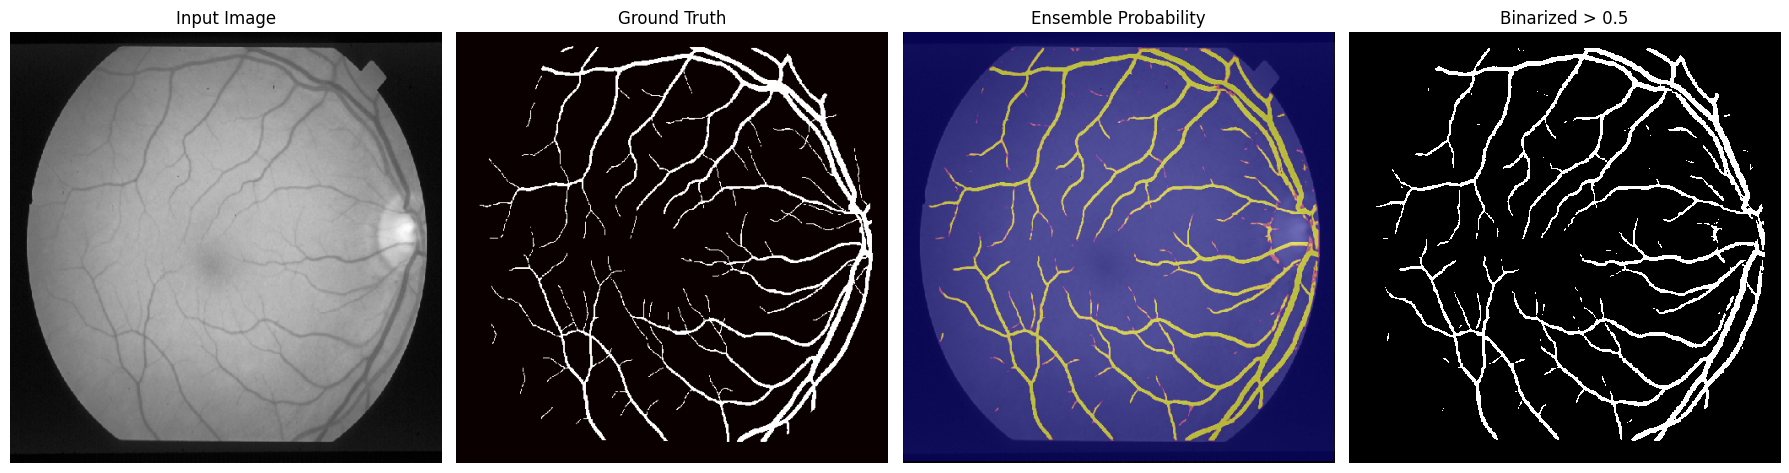

In [38]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import monai

def visual_evaluation_4panels_ensemble(sample, models, device, method='average', threshold_val=0.5):
    """
    Visual evaluation with an ensemble (4 subplots):
      1) Input image
      2) Ground truth (if present)
      3) Ensemble probability map
      4) Binarized ensemble output
    
    Args:
        sample (dict): A dictionary with keys at least "img". Optionally "mask" and "valid_mask".
        models (list): List of PyTorch models for the ensemble.
        device (torch.device): Where models are loaded (CPU/CUDA).
        method (str): 'average' or 'vote' for ensemble combination.
        threshold_val (float): Threshold to binarize probability map.
    """
    sigmoid = torch.nn.Sigmoid()
    threshold_monai = monai.transforms.AsDiscrete(threshold_values=True)

    # 1) Prepare input image
    img_tensor = sample["img"].float().to(device)
    if img_tensor.dim() == 3:
        # shape [1, H, W] → add batch dimension
        img_tensor = img_tensor.unsqueeze(0)  # [B=1, C=1, H, W]
    img_np = sample["img"].squeeze().cpu().numpy()  # for plotting

    # 2) Optional ground truth
    has_gt = ("mask" in sample)

    # 3) Ensemble inference
    with torch.no_grad():
        preds = []
        for model in models:
            model.eval()
            output = model(img_tensor)       # raw logits shape: [1, 1, H, W]
            probs = sigmoid(output)          # convert to probabilities
            preds.append(probs.cpu())

        # Combine ensemble predictions
        if method == 'average':
            # Soft probability average
            combined = torch.stack(preds).mean(dim=0)  # [1, 1, H, W]
        elif method == 'vote':
            # majority vote among binarized preds
            binarized = [threshold_monai(p) for p in preds]  # each is 0 or 1
            combined = torch.stack(binarized).float().mean(dim=0)
            # combined is in [0..1], e.g. 0.6 means 3 of 5 models said "1"
        else:
            raise ValueError(f"Unsupported ensemble method: {method}")

    # Convert to NumPy
    combined_probs_np = combined.squeeze().numpy()  # shape [H, W], values in [0..1]
    
    # 4) Optionally apply valid_mask
    if "valid_mask" in sample:
        valid = sample["valid_mask"].squeeze().cpu().numpy()
        combined_probs_np *= valid

    # 5) Binarize final ensemble
    combined_bin_np = (combined_probs_np > threshold_val).astype(np.uint8)

    # ----- Plotting -----
    fig, axes = plt.subplots(1, 4, figsize=(18, 5))

    # (A) Input Image
    axes[0].imshow(img_np, cmap='gray')
    axes[0].set_title("Input Image")
    axes[0].axis("off")

    # (B) Ground Truth (if present)
    if has_gt:
        gt_np = sample["mask"].squeeze().cpu().numpy()
        axes[1].imshow(gt_np, cmap='hot')
        axes[1].set_title("Ground Truth")
    else:
        axes[1].text(0.5, 0.5, "No GT Provided",
                     ha="center", va="center", fontsize=12)
    axes[1].axis("off")

    # (C) Ensemble Probability
    # show continuous [0..1] map
    #axes[2].imshow(combined_probs_np, cmap='plasma', vmin=0.1, vmax=0.8)
    masked_probs = np.ma.masked_where(valid == 0, combined_probs_np)
    axes[2].imshow(img_np, cmap='gray')
    axes[2].imshow(masked_probs, cmap='plasma', alpha=0.6)
    
    axes[2].set_title("Ensemble Probability")
    axes[2].axis("off")

    # (D) Binarized Ensemble
    axes[3].imshow(combined_bin_np, cmap='gray', interpolation='none')
    axes[3].set_title(f"Binarized > {threshold_val}")
    axes[3].axis("off")

    plt.tight_layout()
    plt.savefig("ensemble_4panel_sample.png", bbox_inches='tight', dpi=300)

    plt.show()

val_loader = monai.data.DataLoader(val_dataset, batch_size=1)


for sample in val_loader:
    print("Test Image dtype:", sample["img"].dtype)  # Should be torch.float32
    #print("Test Mask dtype:", sample["mask"].dtype)  # Should be torch.float32
    print("Test Image shape:", sample["img"].shape)  # Should be [1, 1, 512, 512]
    break
    
for sample in val_loader:
    visual_evaluation_4panels_ensemble(sample, best_saved_models, device, method='average', threshold_val=0.5)
    break


🔍 Showing Sample 7


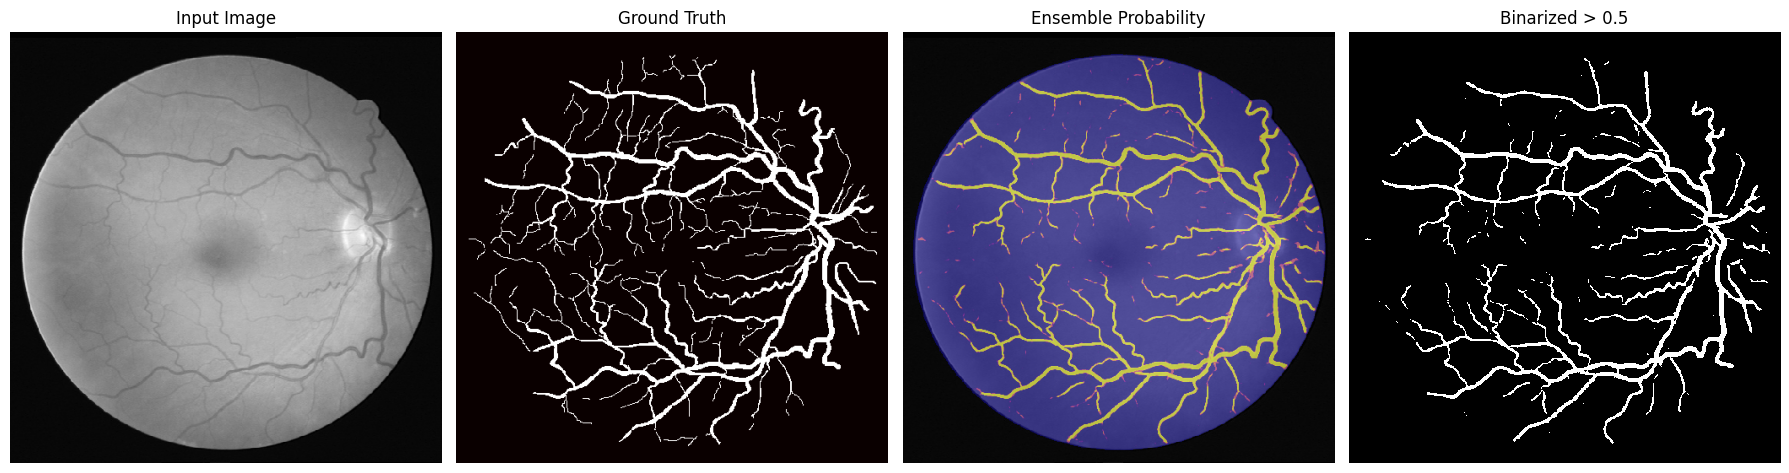

In [39]:
for i, sample in enumerate(val_loader):
    if i == 6:
        print(f"🔍 Showing Sample {i + 1}")
        visual_evaluation_4panels_ensemble(sample, best_saved_models, device, method='average', threshold_val=0.5)
        break


<hr>

### Secret test dataset

In [108]:
def build_dict_vessels(data_path, mode='training'):
    """
    Builds a list of dictionaries containing paths to images, segmentation masks (if available),
    and valid region masks (if available) for the DRIVE-like dataset.

    Returns:
        List[Dict[str, str]]: Each dict contains keys:
            'img'         → path to image
            'mask'        → path to vessel segmentation (optional)
            'valid_mask'  → path to field-of-view mask (optional)
    """
    if mode not in ["training", "test"]:
        raise ValueError(f"Please choose a mode in ['training', 'test']. Current mode is '{mode}'.")

    dicts = []
    image_glob = os.path.join(data_path, mode, '*.tif')
    paths_retina = sorted(glob.glob(image_glob))

    print(f"🔎 Found {len(paths_retina)} images in: {image_glob}")

    for retina_path in paths_retina:
        filename = os.path.basename(retina_path)
        image_index = filename.split('_')[0].split('.')[0]  # handles both "01_test.tif" and "53_secret.tif"

        mask_path = os.path.join(data_path, mode, '1st_manual', f'{image_index}_manual1.gif')
        padding_mask_path = os.path.join(data_path, mode, 'mask', f'{image_index}_{mode}_mask.gif')

        entry = {'img': retina_path,
                 'name': filename}

        if os.path.exists(mask_path):
            entry['mask'] = mask_path
        if os.path.exists(padding_mask_path):
            entry['valid_mask'] = padding_mask_path

        dicts.append(entry)

    if not dicts:
        print("⚠️ No usable samples were found. Check your folder structure or file names.")

    return dicts


secret_dataset = "../datasets/drive_secret/"
new_test_dict_list = build_dict_vessels(secret_dataset, mode='test')
if os.path.exists(secret_dataset):
    print(" exist")
    for i in os.listdir(secret_dataset):
        print(i)
        break
    
print(f'Number of samples in the test dataset: {len(new_test_dict_list)}')


#########à
from monai.transforms import Compose, EnsureTyped

test_transform = Compose([
    LoadVesselData(),
    EnsureTyped(keys=["img"], allow_missing_keys=True)
])

new_test_dataset = monai.data.CacheDataset(new_test_dict_list, transform=test_transform)

#########


test_loader = monai.data.DataLoader(new_test_dataset, batch_size=1)


def run_ensemble_inference_and_save(config, str_models, test_loader, best_saved_models, device, forced_size=(605, 700), threshold_val=0.5):
    """
    Runs ensemble inference on test_loader, saves binarized masks with original names,
    zips them, and deletes individual files after archiving.

    Args:
        config (dict): Config dictionary containing 'save_model', 'save_path', 'zip_filename'
        str_models (str): Identifier string for the ensemble model
        test_loader (DataLoader): DataLoader for test set
        best_saved_models (list): List of loaded PyTorch models
        device (torch.device): Device to run inference on
        forced_size (tuple): Final size to resize prediction masks to (H, W)
        threshold_val (float): Threshold to binarize the prediction
    """
    save_outputs = '/'.join(config['save_model'].split('/')[:-1])  # parent of save_model
    os.makedirs(save_outputs, exist_ok=True)

    save_path = f"{config['save_path']}_{str_models}_secret_dataset"
    zip_filename = f"{config['zip_filename']}_{str_models}__secret_dataset.zip"
    os.makedirs(save_path, exist_ok=True)

    print("🧠 Running ensemble prediction and saving masks...")
    for i, sample in enumerate(tqdm(test_loader), 1):
        image = sample["img"].to(device)

        if image.dim() == 3:
            image = image.unsqueeze(0)  # [1, 1, H, W]

        with torch.no_grad():
            preds = []
            for m in best_saved_models:
                m.eval()
                out = m(image)
                probs = torch.sigmoid(out)
                preds.append(probs.cpu())

            combined = torch.stack(preds).mean(dim=0)
            binary_mask = (combined > threshold_val).float()

        # Resize output mask
        resized_mask = F.interpolate(binary_mask, size=forced_size, mode='nearest')
        resized_mask_np = resized_mask.squeeze().cpu().numpy().astype(np.uint8) * 255

        # Save image with original name
        original_name = sample["name"][0] if isinstance(sample["name"], list) else sample["name"]
        filename = os.path.join(save_path, original_name.replace('.tif', '.png'))
        cv2.imwrite(filename, resized_mask_np)

    print(f"✅ Saved all ensemble masks to: {save_path}")

    # Zip all saved images
    print("📦 Creating zip archive...")
    with zipfile.ZipFile(zip_filename, 'w') as zipf:
        for file in os.listdir(save_path):
            if file.endswith(".png"):
                zipf.write(os.path.join(save_path, file), arcname=file)

    print(f"✅ Zip file created: {zip_filename}")

    # Clean up individual PNGs
    print("🧹 Cleaning up PNG files...")
    for file in os.listdir(save_path):
        file_path = os.path.join(save_path, file)
        if file.endswith(".png") and os.path.isfile(file_path):
            os.remove(file_path)

    os.rmdir(save_path)
    print(f"✅ Cleaned up image files from: {save_path}")


run_ensemble_inference_and_save(config, str_models, test_loader, best_saved_models, device)


🔎 Found 20 images in: ../datasets/drive_secret/test/*.tif
 exist
53_secret.tif
Number of samples in the test dataset: 20


Loading dataset: 100%|██████████| 20/20 [00:00<00:00, 312.56it/s]


🧠 Running ensemble prediction and saving masks...


100%|██████████| 20/20 [00:03<00:00,  5.05it/s]

✅ Saved all ensemble masks to: ../saved_outputs/output_images_swin_model___dropout_UNet_secret_dataset
📦 Creating zip archive...
✅ Zip file created: ../saved_outputs/segmentation_outputs_swin_model___dropout_UNet__secret_dataset.zip
🧹 Cleaning up PNG files...
✅ Cleaned up image files from: ../saved_outputs/output_images_swin_model___dropout_UNet_secret_dataset


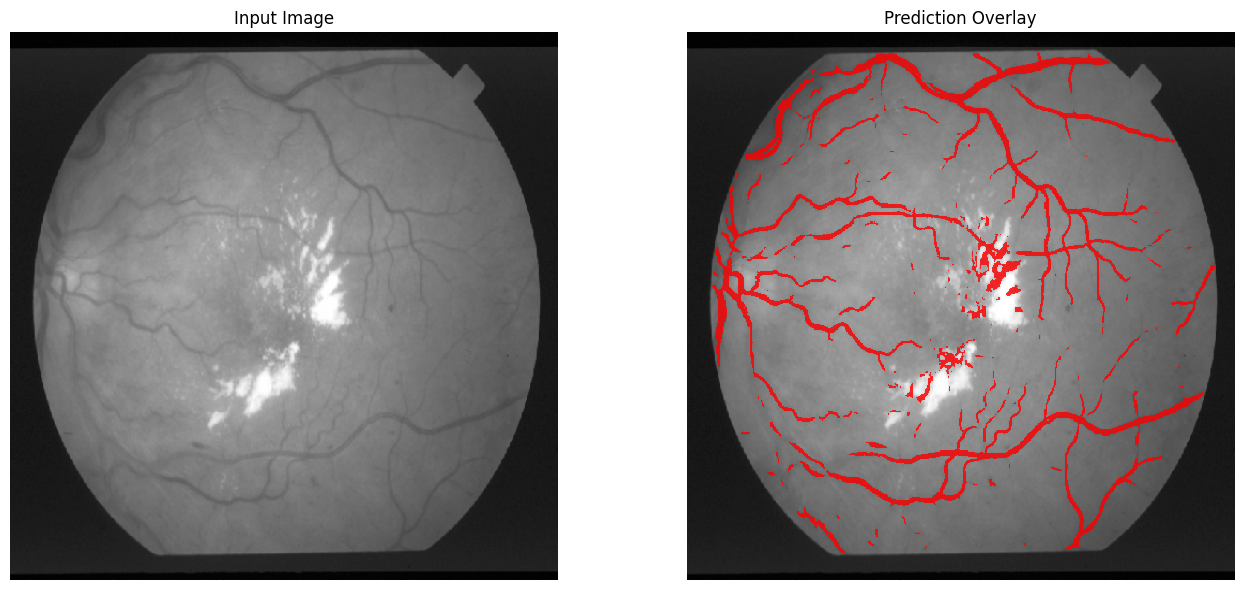

In [100]:
for sample in test_loader:
    visual_evaluation_nomask_ensemble(sample, best_saved_models,device)
    break